In [2]:
using Plots, FastGaussQuadrature, HaltonSequences, Random, QuadGK

# Homework 5

##
Consider the following integration problem:
\begin{align}
  I = \int_a^1 c\cdot x^{-k-1}(1-x)^{k+1}dx.
\end{align}
Assume $a = 10^{-5}$, $c=10^{-9}$, and $k=2$.


### Plot (multiple) graphs of the integrand to have a basic understanding of the problem. As you can see from the equation, the integrand may be tricky when $x$ approaches 0 and when $x$ approaches 1. Therefore, plot the graphs that highlight the integrand's shape near x=0 and x=1.

g(0.8) = 1.5624999999999988e-11


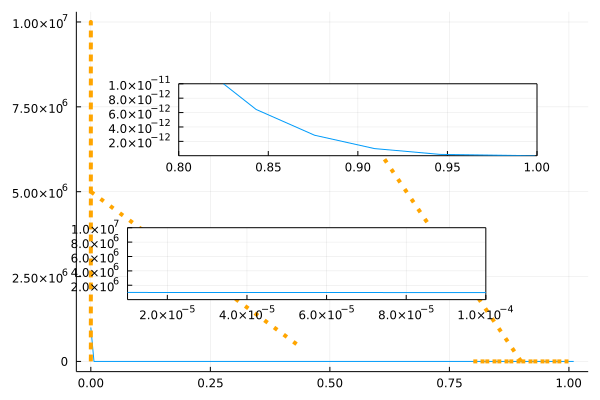

In [17]:
mutable struct integral_param
    floor::Float64
    ceiling::Float64
    g::Function
    nodesNum_max::Int64
    prec::Int64
    integral_param(floor, ceiling, g) = new(floor, ceiling, g)
end

g(x, c=1e-9, k=2) = c * x^(-k-1) * (1-x)^(k+1)
param = integral_param(1e-5, 1., g)

#plot(g, xlim=[1e-5, 1.01], label="")
#lens!([1e-5, 1e-4], [1e3, 1e7],  inset=(1, bbox(0.1, 0.2, 0.7, 0.2, :bottom, :left)),
#      subplot=2, framestyle=:box, lw=4, ls=:dot, lc=:orange)
#lens!([0.8, 1], [1e-15, 1e-11],  inset=(1, bbox(0.1, 0.2, 0.7, 0.2, :top, :right)),
#       subplot=2, framestyle=:box, lw=4, ls=:dot, lc=:orange)

### Use the Gauss-Legendre rule to compute the integral. How many nodes are required to have a stable solution (say, five digits after the decimal point are unchanged) ?
- Hint: A lot of nodes.

In [ ]:
function domain_trans_1(p::integral_param)
    x(t) = (p.floor+p.ceiling)/2 +(p.ceiling-p.floor)*t/2
    jcb(t) = (p.ceiling-p.floor)/2
    return f(t) = p.g(x(t)) * jcb(t)
end


function gauss_legendre(p::integral_param)
    f = domain_trans_1(p)
    GL_res = zeros(p.nodesNum_max)
    xi, wi = gausslegendre(1)
    GL_res[1] = f(xi[1]) * wi[1]
    for i = 2:p.nodesNum_max
        xi, wi = gausslegendre(i)
        GL_res[i] = f.(xi)' * wi
        (string(GL_res[i])[3:3+p.prec-1] == string(GL_res[i-1])[3:3+p.prec-1]) && break
    end

    index = findfirst(isequal(0), GL_res)
    (index == nothing) ? error("need more nodes") : (return GL_res[begin:index-1])
end

#param.nodesNum_max, param.prec = 2000, 5
#GL_res = gauss_legendre(param)
#len = length(GL_res)
#@show len
#plot(1:len, GL_res, label="")

### Use the Quasi-Monte Carlo method with the Halton sequence to compute the integral. How long does the sequence need to be in order to have a stable solution (2 digits after the decimal point)?
- Hint: A very long sequence.
- Hint: The following generates a Halton sequence of length 100 with the base number=2: `using HaltonSequences;` `lds=Halton(2,100)`.

In [ ]:
function domain_trans_2(p::integral_param)
    x(t) = p.floor + (p.ceiling-p.floor)*t
    jcb(t) = p.ceiling-p.floor
    return f(t) = p.g(x(t)) * jcb(t)
end


function qua_MCM(p::integral_param, prime::Int64)
    f = domain_trans_2(p)
    qua_MCM_res = zeros(p.nodesNum_max)
    qua_MCM_res[1] = f(Halton(prime, length=1)[1])
    for i = 2:p.nodesNum_max
        qua_MCM_res[i] = sum(f.(Halton(prime, length=i))) / i
        #(string(qua_MCM_res[i])[3:3+p.prec-1] == string(qua_MCM_res[i-1])[3:3+p.prec-1]) && break
    end

    #index = findfirst(isequal(0), qua_MCM_res)
    #(index == nothing) ? error("need more nodes") : (return qua_MCM_res[begin:index-1])
end

param.nodesNum_max, param.prec = 1500000, 2
qua_MCM_res = qua_MCM(param, 2)
#len = length(qua_MCM_res)
#@show len
plot(1:1500000, qua_MCM_res, label="")

### Use the Monte Carlo method (with random numbers) to compute the integral. How many random numbers do you need to draw in order to have a stable solution (2 digits after the decimal point)? Is the number of random draws larger than the length of the Halton sequence you used in the previous question?
- Hint: A lot of random numbers.

In [ ]:
function MCM(p::integral_param)
    f = domain_trans_2(p)
    MCM_res = zeros(p.nodesNum_max)
    MCM_res[1] = f(rand(Xoshiro(1234)))
    for i = 2:p.nodesNum_max
        uni_seq = rand(Xoshiro(1234), i)
        MCM_res[i] = sum(f.(uni_seq)) / i
        (string(MCM_res[i])[3:3+p.prec-1] == string(MCM_res[i-1])[3:3+p.prec-1]) && break
    end

    index = findfirst(isequal(0), MCM_res)
    (index == nothing) ? error("need more nodes") : (return MCM_res[begin:index-1])
end

#MCM_res = MCM(param)
#len = length(MCM_res)
#@show len
#plot(1:len, MCM_res, label="")

### Julia provides a package `QuadGK.jl` which has a function `quadgk()` that uses *adaptive quadratures* to do one-dimensional numerical integration. Use `using Pkg; Pkg.add("QuadGK.jl")` to install it, and `using QuadGK` to call it.
- Please read Section 1.3 on `Lec4 Numerical Integration - class.ipynb` to understand what is adaptive quadratures.
- Use `quadgk()` function to compute the integration.

In [ ]:
#quadgk_res, err = quadgk(g, a, 1)
#quadgk_res

### You tried several methods to calculate the integration: The Gauss-Legendre method, the quasi-Monte Carlo method using the Halton sequence, the Monte Carlo method using random draws, and the adaptive quadrature method. How would you rank the methods from the most efficient (in terms of using a smaller number of draws/points, which usually translates to shorter run time) to the least efficient? Please explain the possible reasons behind the most and the least efficient methods.

- I think the most efficien method is the adaptive quadrature method and the following are the Gauss Legendre method and the Quasi MCM, howerver the least efficient method is the MCM
- the reason for the Gauss quadrature methods being more efficient than the MCM methods is the problem is one dimensional and the method is will defined throush root solving problem of the specific polynomial
- the reason for the adaptive quadrature method to be the most efficient is
- the reason for the MCM method to be the least efficient is the randomness of the nodes